CRISIS MULTIMODAL CLASSIFICATION SYSTEM
Device: cuda
CUDA available: True
GPU: Tesla T4

Loading datasets...

PART 1: TEXT CLASSIFIER - INFORMATIVE VS NON-INFORMATIVE TWEETS


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Dataset Statistics:
  Train samples: 12000
  Val samples: 2000
  Test samples: 2000
  Classes: 2 (Informative, Non-informative)
  Class distribution: [7316, 4684]
  Class weights: [0.8201203 1.2809565]

Training Text Classifier...
----------------------------------------------------------------------


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.557900,0.556325,0.720000,0.701964,0.720953
2,0.448600,0.577451,0.750000,0.726346,0.747184
3,0.238100,0.735671,0.738500,0.715294,0.736346



TEXT CLASSIFIER - TEST SET RESULTS
                 precision    recall  f1-score   support

    Informative     0.7652    0.8327    0.7975      1237
Non-informative     0.6835    0.5858    0.6309       763

       accuracy                         0.7385      2000
      macro avg     0.7244    0.7093    0.7142      2000
   weighted avg     0.7340    0.7385    0.7340      2000



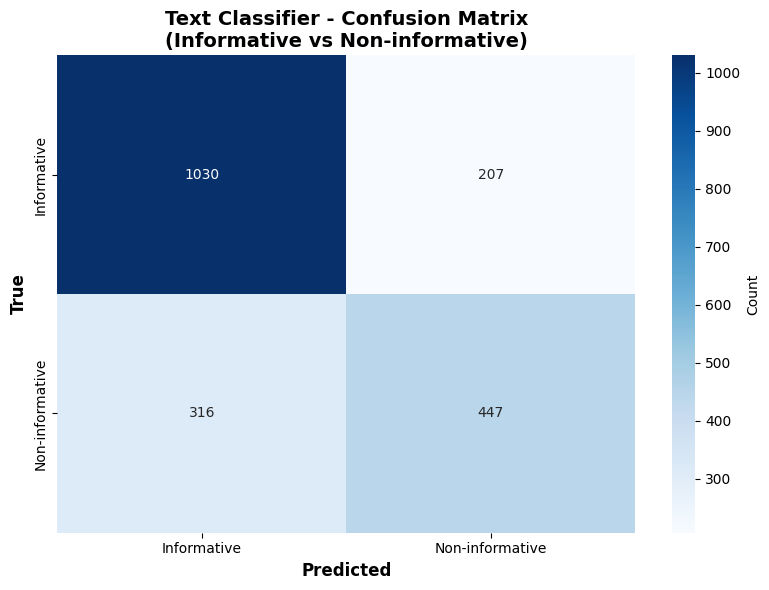


✓ Text classifier trained successfully!
  Macro F1: 0.7142
  Weighted F1: 0.7340
  Accuracy: 0.7385

PART 2: MULTIMODAL CLASSIFIER - HUMANITARIAN CATEGORIES

Filtering rare classes (< 50 samples): {3}


Filter:   0%|          | 0/12000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]


Dataset Statistics:
  Train samples: 11978
  Val samples: 1996
  Test samples: 1996
  Classes: 7 humanitarian categories
  Class distribution: [381, 1686, 210, 4636, 2875, 2068, 122]
  Class weights: [ 4.4911885   1.0149127   8.148299    0.369099    0.59518015  0.82743853
 14.025761  ]

Model Architecture:
  Text encoder: google-bert/bert-base-uncased
  Image encoder: efficientnet_b0.ra_in1k
  Fusion: Cross-modal attention
  Total parameters: 115,988,867

Training Multimodal Classifier...
----------------------------------------------------------------------
Epoch 1/6 | Loss: 1.3413 | Val Macro F1: 0.1766 | Val Weighted F1: 0.2117 | Val Acc: 0.2806
Epoch 2/6 | Loss: 1.0908 | Val Macro F1: 0.3758 | Val Weighted F1: 0.4278 | Val Acc: 0.4364
Epoch 3/6 | Loss: 0.9266 | Val Macro F1: 0.3525 | Val Weighted F1: 0.4094 | Val Acc: 0.4043
Epoch 4/6 | Loss: 0.7437 | Val Macro F1: 0.4474 | Val Weighted F1: 0.5113 | Val Acc: 0.5115
Epoch 5/6 | Loss: 0.5591 | Val Macro F1: 0.4043 | Val Weighted F1:

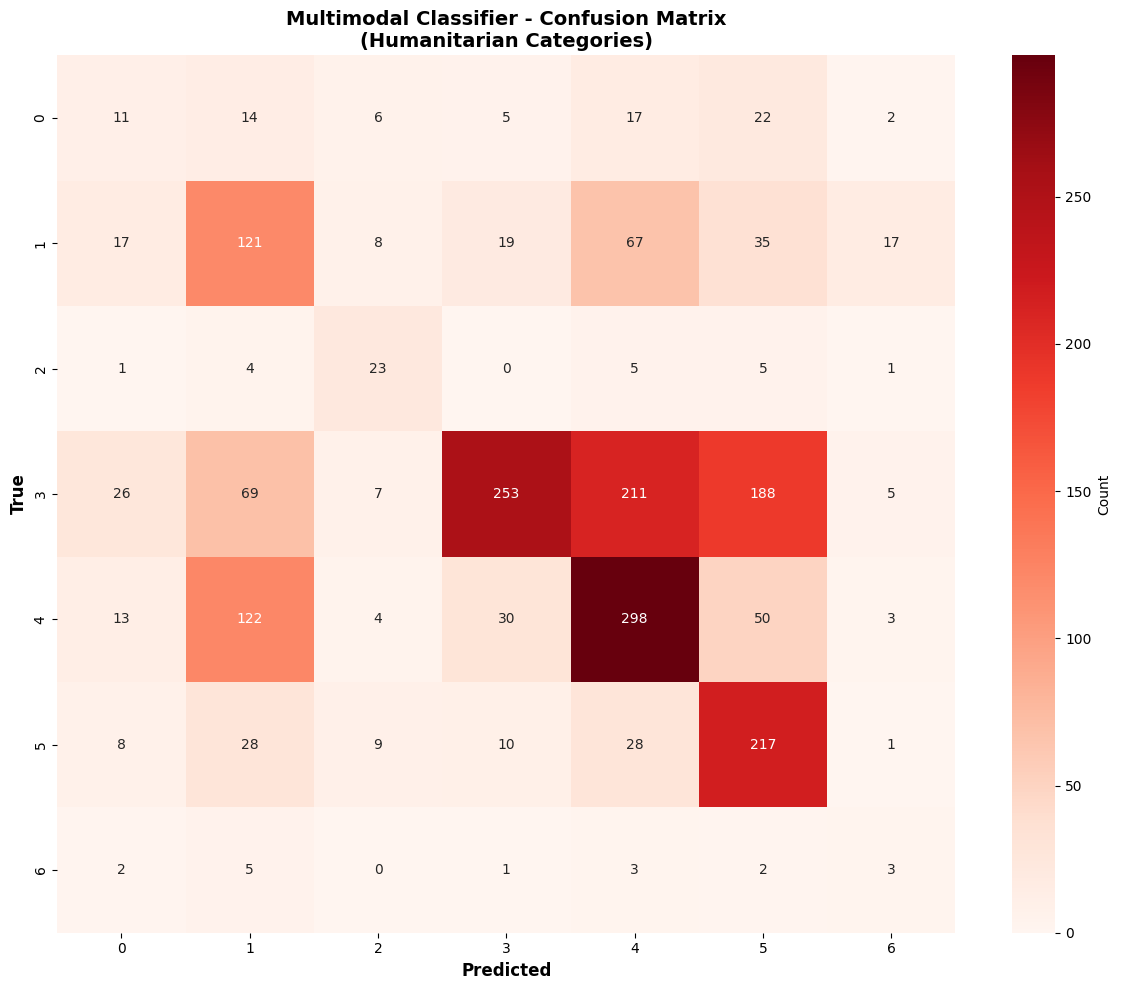


✓ Multimodal classifier evaluated!
  Macro F1: 0.3768
  Weighted F1: 0.4627
  Accuracy: 0.4639


In [ ]:
!pip install -q datasets transformers timm scikit-learn matplotlib seaborn pillow

import os, random, gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          AutoModel, TrainingArguments, Trainer)
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from dataclasses import dataclass
from collections import Counter

@dataclass
class Config:
    """Configuration for Crisis Multimodal Classification System"""
    dataset_name: str = "QCRI/CrisisMMD"
    text_subset: str = "informative"
    multi_subset: str = "humanitarian"
    text_model_name: str = "google-bert/bert-base-uncased"
    image_model_name: str = "efficientnet_b0.ra_in1k"
    max_length: int = 128
    train_batch_size: int = 16
    eval_batch_size: int = 32
    num_epochs_text: int = 3
    num_epochs_multi: int = 6
    lr_text: float = 2e-5
    lr_multi: float = 3e-5
    num_workers: int = 2
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    image_size: int = 224
    max_train_samples: int = 12000
    max_val_samples: int = 2000
    max_test_samples: int = 2000
    warmup_ratio: float = 0.1
    weight_decay: float = 0.01
    focal_gamma: float = 3.0
    rare_class_threshold: int = 50

cfg = Config()

def set_seed(seed: int):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)
device = torch.device(cfg.device)

print("="*70)
print("CRISIS MULTIMODAL CLASSIFICATION SYSTEM")
print("="*70)
print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*70 + "\n")

print("Loading datasets...")
text_ds = load_dataset(cfg.dataset_name, cfg.text_subset)

def subset_splits(ds_dict, max_train, max_val, max_test):
    """Subset dataset splits to manageable sizes"""
    result = {}
    for split_name in ds_dict.keys():
        if "train" in split_name:
            n = min(max_train, len(ds_dict[split_name]))
        elif "dev" in split_name or "validation" in split_name:
            n = min(max_val, len(ds_dict[split_name]))
        else:
            n = min(max_test, len(ds_dict[split_name]))
        result[split_name] = ds_dict[split_name].select(range(n))
    return result

text_ds = subset_splits(text_ds, cfg.max_train_samples, cfg.max_val_samples, cfg.max_test_samples)

def prepare_splits(ds):
    """Prepare train/validation/test splits"""
    if "dev" in ds:
        return {"train": ds["train"], "validation": ds["dev"], "test": ds["test"]}
    elif "validation" in ds:
        return {"train": ds["train"], "validation": ds["validation"], "test": ds["test"]}
    else:
        split = ds["train"].train_test_split(test_size=0.15, seed=cfg.seed)
        return {
            "train": split["train"],
            "validation": split["test"],
            "test": ds["test"] if "test" in ds else split["test"]
        }

text_ds = prepare_splits(text_ds)

print("\n" + "="*70)
print("PART 1: TEXT CLASSIFIER - INFORMATIVE VS NON-INFORMATIVE TWEETS")
print("="*70)

text_tokenizer = AutoTokenizer.from_pretrained(cfg.text_model_name)

def preprocess_text(batch):
    """Tokenize text data"""
    texts = batch["tweet_text"]
    enc = text_tokenizer(texts, truncation=True, padding="max_length", max_length=cfg.max_length)
    enc["labels"] = batch["label"]
    return enc

from datasets import DatasetDict

text_ds_encoded = DatasetDict({
    "train": text_ds["train"].map(preprocess_text, batched=True),
    "validation": text_ds["validation"].map(preprocess_text, batched=True),
    "test": text_ds["test"].map(preprocess_text, batched=True)
})

text_ds_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

labels_list = [label.item() for label in text_ds_encoded["train"]["labels"]]
unique_labels = sorted(set(labels_list))
num_text_labels = len(unique_labels)

label_to_idx = {old_label: new_idx for new_idx, old_label in enumerate(unique_labels)}

def remap_labels(example):
    """Remap labels to contiguous indices"""
    if isinstance(example["labels"], torch.Tensor):
        example["labels"] = label_to_idx[example["labels"].item()]
    else:
        example["labels"] = label_to_idx[example["labels"]]
    return example

text_ds_encoded = text_ds_encoded.map(remap_labels)

label_counts = Counter([label.item() for label in text_ds_encoded["train"]["labels"]])
sorted_counts = [label_counts[i] for i in range(num_text_labels)]
total = sum(sorted_counts)
class_weights = torch.tensor([total / (num_text_labels * c) for c in sorted_counts], dtype=torch.float).to(device)

print(f"\nDataset Statistics:")
print(f"  Train samples: {len(text_ds_encoded['train'])}")
print(f"  Val samples: {len(text_ds_encoded['validation'])}")
print(f"  Test samples: {len(text_ds_encoded['test'])}")
print(f"  Classes: {num_text_labels} (Informative, Non-informative)")
print(f"  Class distribution: {sorted_counts}")
print(f"  Class weights: {class_weights.cpu().numpy()}")

class WeightedTrainer(Trainer):
    """Custom trainer with class-weighted loss"""
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

text_model = AutoModelForSequenceClassification.from_pretrained(
    cfg.text_model_name,
    num_labels=num_text_labels
).to(device)

def compute_metrics(eval_pred):
    """Compute evaluation metrics"""
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "weighted_f1": f1_score(labels, preds, average="weighted")
    }

training_args = TrainingArguments(
    output_dir="./crisismmd-text",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=cfg.train_batch_size,
    per_device_eval_batch_size=cfg.eval_batch_size,
    num_train_epochs=cfg.num_epochs_text,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    warmup_ratio=cfg.warmup_ratio,
    weight_decay=cfg.weight_decay,
    fp16=torch.cuda.is_available(),
    report_to="none",
    save_total_limit=2
)

trainer = WeightedTrainer(
    model=text_model,
    args=training_args,
    train_dataset=text_ds_encoded["train"],
    eval_dataset=text_ds_encoded["validation"],
    processing_class=text_tokenizer,
    compute_metrics=compute_metrics,
)

print("\nTraining Text Classifier...")
print("-" * 70)
trainer.train()

predictions = trainer.predict(text_ds_encoded["test"])
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids

print("\n" + "="*70)
print("TEXT CLASSIFIER - TEST SET RESULTS")
print("="*70)
target_names = ['Informative', 'Non-informative']
print(classification_report(labels, preds, digits=4, target_names=target_names))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count'},
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted", fontsize=12, fontweight='bold')
plt.ylabel("True", fontsize=12, fontweight='bold')
plt.title("Text Classifier - Confusion Matrix\n(Informative vs Non-informative)",
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Text classifier trained successfully!")
print(f"  Macro F1: {f1_score(labels, preds, average='macro'):.4f}")
print(f"  Weighted F1: {f1_score(labels, preds, average='weighted'):.4f}")
print(f"  Accuracy: {accuracy_score(labels, preds):.4f}")

del text_model, trainer
torch.cuda.empty_cache()
gc.collect()

print("\n" + "="*70)
print("PART 2: MULTIMODAL CLASSIFIER - HUMANITARIAN CATEGORIES")
print("="*70)

from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((cfg.image_size, cfg.image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2))
])

image_transform_val = transforms.Compose([
    transforms.Resize((cfg.image_size, cfg.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

multi_ds = load_dataset(cfg.dataset_name, cfg.multi_subset)
multi_ds = subset_splits(multi_ds, cfg.max_train_samples, cfg.max_val_samples, cfg.max_test_samples)
multi_ds = prepare_splits(multi_ds)

multi_labels_list = [sample["label"] for sample in multi_ds["train"]]
label_dist = Counter(multi_labels_list)

rare_labels = {k for k, v in label_dist.items() if v < cfg.rare_class_threshold}
print(f"\nFiltering rare classes (< {cfg.rare_class_threshold} samples): {rare_labels}")

def filter_rare_classes(example):
    """Filter out rare classes with insufficient samples"""
    return example["label"] not in rare_labels

multi_ds["train"] = multi_ds["train"].filter(filter_rare_classes)
multi_ds["validation"] = multi_ds["validation"].filter(filter_rare_classes)
multi_ds["test"] = multi_ds["test"].filter(filter_rare_classes)

multi_labels_list = [sample["label"] for sample in multi_ds["train"]]
unique_multi_labels = sorted(set(multi_labels_list))
num_multi_labels = len(unique_multi_labels)
multi_label_to_idx = {old: new for new, old in enumerate(unique_multi_labels)}

humanitarian_categories = [
    "Affected individuals",
    "Infrastructure damage",
    "Injured or dead people",
    "Missing or found people",
    "Rescue/volunteering",
    "Vehicle damage",
    "Other relevant info"
]

class MultimodalDataset(Dataset):
    """Dataset for multimodal (text + image) input"""
    def __init__(self, hf_split, tokenizer, transform=None, max_length=128, label_map=None):
        self.ds = hf_split
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length
        self.label_map = label_map

        valid_indices = []
        for idx in range(len(self.ds)):
            sample = self.ds[idx]
            has_text = "tweet_text" in sample and sample["tweet_text"] is not None
            has_image = ("image" in sample and sample["image"] is not None) or \
                       ("image_path" in sample and sample["image_path"] is not None)
            if has_text and has_image:
                valid_indices.append(idx)

        self.valid_indices = valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        sample = self.ds[real_idx]
        text = sample["tweet_text"]

        try:
            if "image" in sample and sample["image"] is not None and not isinstance(sample["image"], str):
                image = sample["image"].convert("RGB")
            else:
                img_path = sample.get("image_path", sample.get("image"))
                if img_path is None:
                    raise ValueError("No valid image")
                image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (cfg.image_size, cfg.image_size), (128, 128, 128))

        if self.transform:
            image = self.transform(image)

        encoding = self.tokenizer(text, truncation=True, padding="max_length",
                                 max_length=self.max_length, return_tensors="pt")

        label = sample["label"]
        if self.label_map:
            label = self.label_map[label]

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "image": image,
            "labels": torch.tensor(label, dtype=torch.long),
        }

multi_train = MultimodalDataset(multi_ds["train"], text_tokenizer, transform=image_transform,
                                max_length=cfg.max_length, label_map=multi_label_to_idx)
multi_val = MultimodalDataset(multi_ds["validation"], text_tokenizer, transform=image_transform_val,
                              max_length=cfg.max_length, label_map=multi_label_to_idx)
multi_test = MultimodalDataset(multi_ds["test"], text_tokenizer, transform=image_transform_val,
                               max_length=cfg.max_length, label_map=multi_label_to_idx)

train_multi_loader = DataLoader(multi_train, batch_size=cfg.train_batch_size, shuffle=True,
                                num_workers=cfg.num_workers, pin_memory=True)
val_multi_loader = DataLoader(multi_val, batch_size=cfg.eval_batch_size,
                              num_workers=cfg.num_workers, pin_memory=True)
test_multi_loader = DataLoader(multi_test, batch_size=cfg.eval_batch_size,
                               num_workers=cfg.num_workers, pin_memory=True)

multi_label_counts = Counter()
for batch in train_multi_loader:
    for label in batch["labels"]:
        multi_label_counts[label.item()] += 1

multi_sorted_counts = [multi_label_counts[i] for i in range(num_multi_labels)]
multi_total = sum(multi_sorted_counts)
multi_class_weights = torch.tensor(
    [multi_total / (num_multi_labels * c) if c > 0 else 1.0 for c in multi_sorted_counts],
    dtype=torch.float
).to(device)

print(f"\nDataset Statistics:")
print(f"  Train samples: {len(multi_train)}")
print(f"  Val samples: {len(multi_val)}")
print(f"  Test samples: {len(multi_test)}")
print(f"  Classes: {num_multi_labels} humanitarian categories")
print(f"  Class distribution: {multi_sorted_counts}")
print(f"  Class weights: {multi_class_weights.cpu().numpy()}")

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

class CrossModalAttention(nn.Module):
    """Cross-modal attention mechanism for text-image fusion"""
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** -0.5

    def forward(self, text_feat, image_feat):
        q = self.query(text_feat).unsqueeze(1)
        k = self.key(image_feat).unsqueeze(1)
        v = self.value(image_feat).unsqueeze(1)

        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, v).squeeze(1)
        return out

class MultimodalFusionModel(nn.Module):
    """Multimodal model with cross-modal attention fusion"""
    def __init__(self, text_model_name, image_model_name, num_classes):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.image_encoder = timm.create_model(image_model_name, pretrained=True, num_classes=0)

        text_dim = self.text_encoder.config.hidden_size
        image_dim = self.image_encoder.num_features

        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(image_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.cross_attn = CrossModalAttention(512)

        self.fusion = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
        )

    def forward(self, input_ids, attention_mask, image):
        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_feats = self.text_proj(text_out.last_hidden_state[:, 0, :])

        image_feats = self.image_encoder(image)
        image_feats = self.image_proj(image_feats)

        attended_img = self.cross_attn(text_feats, image_feats)

        fused = torch.cat([text_feats, attended_img], dim=-1)
        return self.fusion(fused)

multi_model = MultimodalFusionModel(cfg.text_model_name, cfg.image_model_name, num_multi_labels).to(device)

print(f"\nModel Architecture:")
print(f"  Text encoder: {cfg.text_model_name}")
print(f"  Image encoder: {cfg.image_model_name}")
print(f"  Fusion: Cross-modal attention")
print(f"  Total parameters: {sum(p.numel() for p in multi_model.parameters()):,}")

def train_multimodal(model, train_loader, val_loader, num_epochs=cfg.num_epochs_multi, lr=cfg.lr_multi):
    """Train multimodal classifier"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
    total_steps = len(train_loader) * num_epochs
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, total_steps=total_steps, pct_start=0.3
    )
    criterion = FocalLoss(alpha=multi_class_weights, gamma=cfg.focal_gamma)
    scaler = torch.amp.GradScaler('cuda')

    best_val_f1 = 0.0
    best_state = None

    print("\nTraining Multimodal Classifier...")
    print("-" * 70)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)

            with torch.amp.autocast('cuda'):
                logits = model(input_ids, attention_mask, images)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            train_loss += loss.item()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                images = batch["image"].to(device)
                labels = batch["labels"].to(device)

                with torch.amp.autocast('cuda'):
                    logits = model(input_ids, attention_mask, images)
                preds = logits.argmax(dim=-1).cpu()
                all_preds.extend(preds.numpy().tolist())
                all_labels.extend(labels.cpu().numpy().tolist())

        val_f1 = f1_score(all_labels, all_preds, average="macro")
        val_weighted_f1 = f1_score(all_labels, all_preds, average="weighted")
        val_acc = accuracy_score(all_labels, all_preds)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Macro F1: {val_f1:.4f} | "
              f"Val Weighted F1: {val_weighted_f1:.4f} | "
              f"Val Acc: {val_acc:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()

    if best_state:
        model.load_state_dict(best_state)
        print(f"\n✓ Loaded best model (val macro F1: {best_val_f1:.4f})")

    return model

multi_model = train_multimodal(multi_model, train_multi_loader, val_multi_loader)

def evaluate_multimodal(model, loader):
    """Evaluate multimodal classifier"""
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)

            with torch.amp.autocast('cuda'):
                logits = model(input_ids, attention_mask, images)
            preds = logits.argmax(dim=-1).cpu()
            all_preds.extend(preds.numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    print("\n" + "="*70)
    print("MULTIMODAL CLASSIFIER - TEST SET RESULTS")
    print("="*70)

    category_names = [humanitarian_categories[i] for i in range(min(num_multi_labels, len(humanitarian_categories)))]
    if len(category_names) < num_multi_labels:
        category_names.extend([f"Class {i}" for i in range(len(category_names), num_multi_labels)])

    print(classification_report(all_labels, all_preds, digits=4, zero_division=0,
                                target_names=category_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar_kws={'label': 'Count'})
    plt.xlabel("Predicted", fontsize=12, fontweight='bold')
    plt.ylabel("True", fontsize=12, fontweight='bold')
    plt.title("Multimodal Classifier - Confusion Matrix\n(Humanitarian Categories)",
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n✓ Multimodal classifier evaluated!")
    print(f"  Macro F1: {f1_score(all_labels, all_preds, average='macro'):.4f}")
    print(f"  Weighted F1: {f1_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"  Accuracy: {accuracy_score(all_labels, all_preds):.4f}")

evaluate_multimodal(multi_model, test_multi_loader)
